In [1]:
import numpy as np
import matplotlib.pyplot as plt
import histlite
from tqdm.notebook import tqdm
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('/p/lustre1/yu47/Sterile_Neutrino/sensitivity/')

from neutrino_source import neutrino_source
from detector import detector
from MC_generator import gen_LZ
from MC_generator import MC_generator
from fitter import fitter

A Cr51 hot neutrino source with nominal 100000.0 in xx years with neutrino energies [0.75] and branch ratios [1.0] is created.


# Fitter in sterile neutrino study
One needs to initialize a fitter instance first, where the detector and source instances should be provided as inputs. As during the fitting, one is expected to calculate the prediction spectrum in some functions.

## Oscillation parameters
For oscillation parameter pair ($\Delta m^2, \sin^2(2\theta)$), there two sets of paramters in the fitter -- one for the data and one for the fitting. Especially for the Asimov dataset fitting, as I am calculating the dataset and PDF in real-time, one needs to specify thoese parameters before fitting.

In [2]:
# nEXO exp
source_nEXO = neutrino_source('Cr51', 1e5, [0.75], [1.0])
det_nEXO = detector('nEXO')
det_nEXO.update_geometry(1.183, 1.133)
det_nEXO.position = (0, 0, 0)
dist = 0.1
source_nEXO.position = (0, 0, -det_nEXO.height/2-dist)
det_nEXO.run_time = 100 # days

#dm2, sin2theta_square = 0.0, 0.0
#gen1 = MC_generator(source_nEXO, det_nEXO, dm2=dm2, sin2theta_square=sin2theta_square, int_type='CC'); 

my_fit = fitter(source_nEXO, det_nEXO)

A Cr51 hot neutrino source with nominal 100000.0 in xx years with neutrino energies [0.75] and branch ratios [1.0] is created.


0.0
0.0


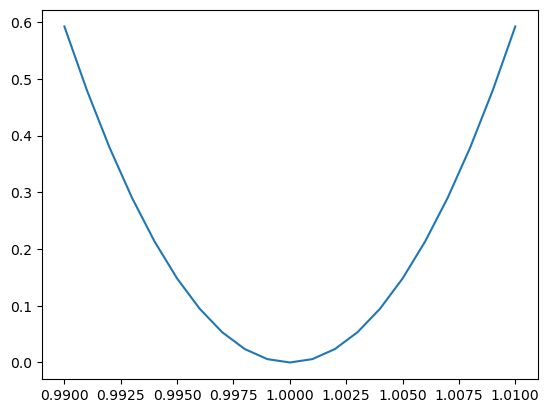

In [3]:
my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)
my_fit._set_fit_dm2(0.0)
my_fit._set_fit_sin2(0.0)
dchi2_0_shape = my_fit.calculate_shape_only_dchi2_asimov_fixedRate()
#dchi2_0 = my_fit.calculate_rateonly_dchi2_asimov()
print(dchi2_0_shape)

dchi2_0_rate = my_fit.calculate_shape_only_dchi2_asimov_fixedRate()
print(dchi2_0_rate)

coarse_R, coarse_dchi2, fine_R, fine_dchi2 = my_fit.calculate_shape_only_dchi2_asimov_scanRate()
#plt.plot(coarse_R, coarse_dchi2)
plt.plot(fine_R, fine_dchi2)

## Asimov dataset fitting
There is no fluctuation in Asimov dataset. In the current codes, the asimov dataset and PDFs are calculated when the fitting function is invoked, not pre-generated for now. There are total three methods under studied:

1. Rate-only method: we do not use any spectral informaion, instead, we only use the expected counts to construct the test statistics as $\Delta \chi^2 = \frac{(P-D)^2}{\sigma^2}$ (where $P$ is the predicted signal count, $D$ and $\sigma$ are the measured signal count and corresponding error -- Poisson for now);

2. Shape-only fixed method: we calculate the 

In [12]:
def get_2d_chi2(method, dm2_arr, sin2_arr, data_dm2=0.0, data_sin2=0.0, ):
    my_fit._set_data_dm2(data_dm2)
    my_fit._set_data_sin2(data_sin2)
    Ndm2 = len(dm2_arr)
    Nsin2 = len(sin2_arr)
    R_arr = np.zeros((Ndm2, Nsin2))
    dchi2_arr = np.zeros((Ndm2, Nsin2))
    for i, my_fit_dm2 in tqdm( enumerate(dm2_arr) ):
        for j, my_fit_sin2 in enumerate(sin2_arr):
            my_fit._set_fit_dm2(my_fit_dm2)
            my_fit._set_fit_sin2(my_fit_sin2)
            Rmin = 0.
            if method == 'rate-only':
                dchi2 = my_fit.calculate_rateonly_dchi2_asimov()
            elif method == 'shape-only-fixed':
                dchi2 = my_fit.calculate_shape_only_dchi2_asimov_fixedRate()
            elif method == 'shape-only-scan':
                _, _, fine_R, fine_dchi2 = my_fit.calculate_shape_only_dchi2_asimov_scanRate()
                Rmin = fine_R[np.argmin(fine_dchi2)]
                dchi2 = np.min(fine_dchi2)
            else:
                print(f'There is no such a method {method}')
                return R_arr, dchi2_arr

            R_arr[Ndm2-1-i, j] = Rmin
            dchi2_arr[Ndm2-1-i, j] = dchi2

    return R_arr, dchi2_arr


In [36]:
def plot_2d(dm2_arr, sin2_arr, R_arr, dchi2_arr, method='rate-only', plotR=False, contour=False, levels=[]):
    from matplotlib import colors
    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.pcolormesh(sin2_arr, dm2_arr, dchi2_arr[::-1, :], norm=colors.LogNorm(vmin=np.min(dchi2_arr), vmax=np.max(dchi2_arr)))

    if contour:
        X, Y = np.meshgrid(sin2_arr, dm2_arr)
        if len(levels) == 0:
            levels = [ 4.605, 5.991,  9.210]
        CS = ax.contour(X, Y, dchi2_arr[::-1, :], levels=levels, colors=['blue', 'red', 'orange', ])
        #ax.clabel(CS, inline=True, fontsize=16)

    ax.loglog()
    cb = plt.colorbar(im, ax=ax)
    ax.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
    ax.set_ylabel(r'$\Delta m^2$', fontsize=14)
    ax.tick_params(labelsize=13)
    cb.set_label(r'$\Delta\chi^2$', fontsize=14, rotation=270, labelpad=25)
    cb.ax.tick_params(labelsize=14)
    ax.set_title(f'Asimov dataset: {method}', fontsize=14, pad=15)

    if plotR:
        fig, ax0 = plt.subplots(figsize=(8, 6))
        im = ax0.pcolormesh(sin2_arr, dm2_arr, R_arr[::-1, :], )
        ax0.loglog()
        cb = plt.colorbar(im, ax=ax0)
        ax0.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
        ax0.set_ylabel(r'$\Delta m^2$', fontsize=14)
        ax0.tick_params(labelsize=13)
        cb.set_label(r'$R_\mathrm{fit}$', fontsize=14, rotation=270, labelpad=25)
        cb.ax.tick_params(labelsize=14)
        ax0.set_title(f'Asimov dataset: {method}', fontsize=14, pad=15)

    plt.tight_layout()

    if contour:
        x_coords_arr, y_coords_arr = [], []
        for i, collection in enumerate(CS.collections):
            for path in collection.get_paths():
                v = path.vertices
                x_coords = v[:, 0]
                y_coords = v[:, 1]
                
                sorted_indices = np.argsort(y_coords)
                y_coords_sorted = y_coords[sorted_indices]
                x_coords_sorted = x_coords[sorted_indices]
                
                x_coords_arr.append( x_coords_sorted )
                y_coords_arr.append( y_coords_sorted )
    
        return fig, x_coords_arr, y_coords_arr
    return fig

In [27]:
### Rate-only dchi2 calculation with Asimov dataset:

dm2_arr = np.logspace(-2, 2, 100)
sin2_arr = np.logspace(-2, 0, 100)

#_, dchi2_arr_rate       = get_2d_chi2('rate-only', dm2_arr, sin2_arr)
_, dchi2_arr_shape_fix  = get_2d_chi2('shape-only-fixed', dm2_arr, sin2_arr)
#R_arr_shape_scan, dchi2_arr_shape_scan = get_2d_chi2('shape-only-scan', dm2_arr, sin2_arr)

100it [35:32, 21.32s/it]


/var/tmp/yu47/ipykernel_2049570/1347890148.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(CS.collections):


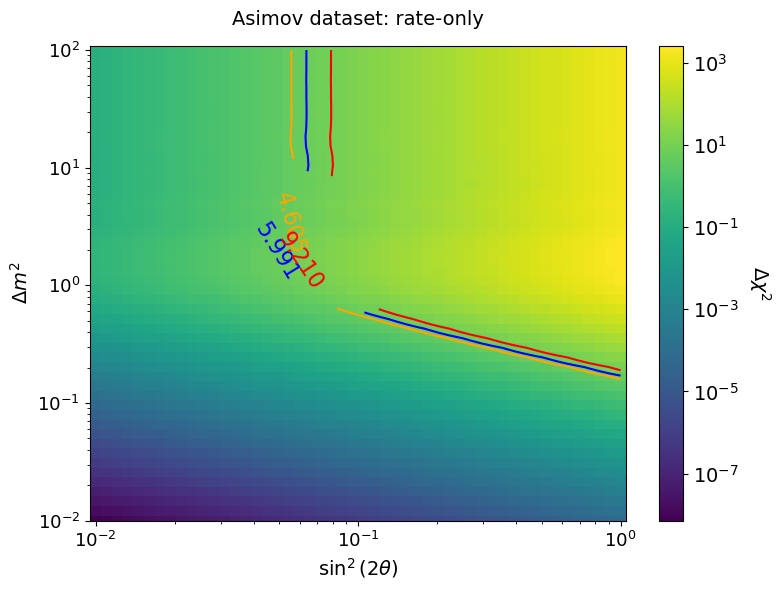

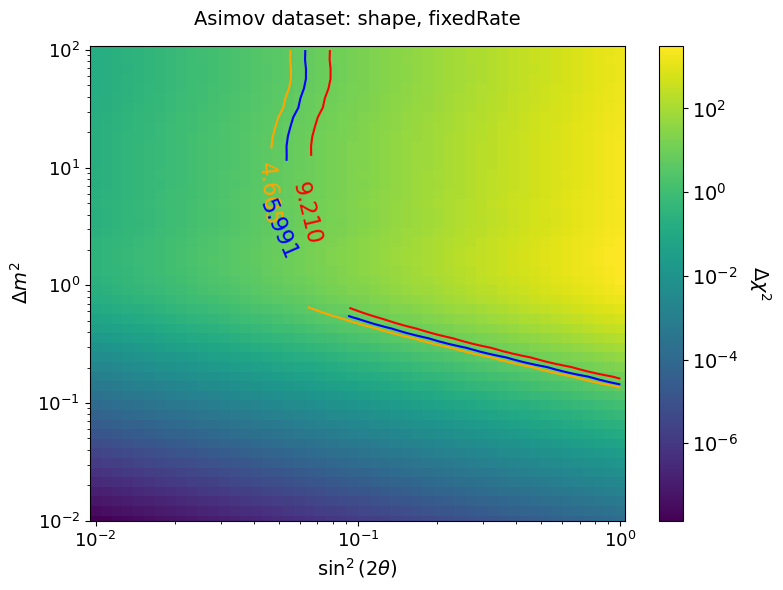

In [25]:
#fig0, x0, y0 = plot_2d(dm2_arr, sin2_arr,[], dchi2_arr_rate, method='rate-only', plotR=False) 
fig1, x1, y1 = plot_2d(dm2_arr, sin2_arr,[], dchi2_arr_shape_fix, method='shape, fixedRate', plotR=False) 
#fig2, x2, y2 = plot_2d(dm2_arr, sin2_arr, R_arr_shape_scan, dchi2_arr_shape_scan, method='shape, scanRate', plotR=True) 

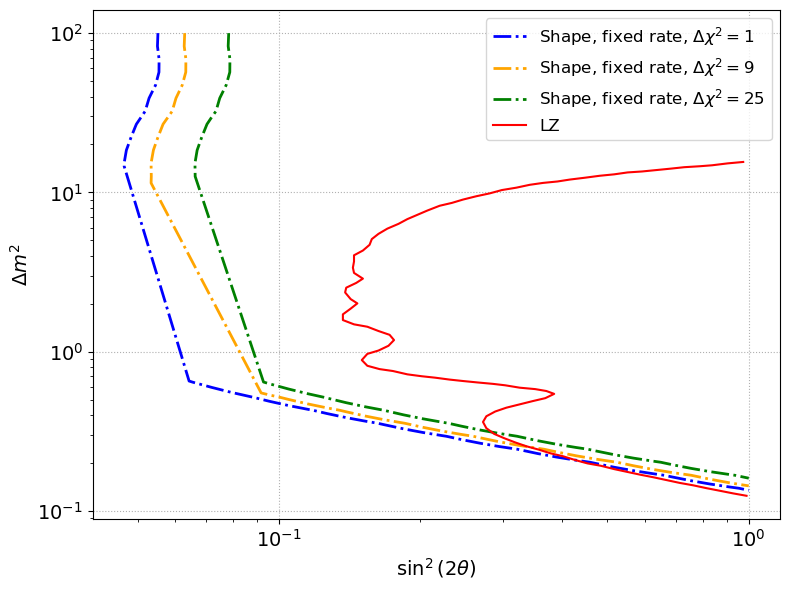

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

#ax.plot(x0[0], y0[0], color='blue', lw=2,  label=r'Rate-only, $\Delta\chi^2=25$')
#ax.plot(x0[1], y0[1], color='orange', lw=2,  label=r'Rate-only, $\Delta\chi^2=9$')
#ax.plot(x0[2], y0[2], color='green', lw=2,  label=r'Rate-only, $\Delta\chi^2=1$')
ax.plot(x1[0], y1[0], color='blue', lw=2, linestyle='-.', label=r'Shape, fixed rate, $\Delta\chi^2=1$')
ax.plot(x1[1], y1[1], color='orange', lw=2, linestyle='-.', label=r'Shape, fixed rate, $\Delta\chi^2=9$')
ax.plot(x1[2], y1[2], color='green', lw=2, linestyle='-.', label=r'Shape, fixed rate, $\Delta\chi^2=25$')
#ax.plot(x2[0], y2[0], color='blue', lw=2, linestyle='--', label=r'Shape, scan rate, $\Delta\chi^2=25$')
#ax.plot(x2[1], y2[1], color='orange', lw=2, linestyle='--', label=r'Shape, scan rate, $\Delta\chi^2=9$')
#ax.plot(x2[2], y2[2], color='green', lw=2, linestyle='--', label=r'Shape, scan rate, $\Delta\chi^2=1$')

arr_shapeonly_LZ_naturalLXe = np.loadtxt('../data/LZ_natural_LXe_shapeonly.csv')
x_LZ, y_LZ = arr_shapeonly_LZ_naturalLXe[:, 0], arr_shapeonly_LZ_naturalLXe[:, 1]
ax.plot(x_LZ, y_LZ, label='LZ', color='red')

ax.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
ax.set_ylabel(r'$\Delta m^2$', fontsize=14)
ax.tick_params(labelsize=14)
ax.loglog()
ax.legend(fontsize=12,)
ax.grid(linestyle=':')
plt.tight_layout()
#plt.savefig('../plots/Asimov_dataset_compareRateAndShapeOnly_deltachi2.pdf')

1.1 39.213117823243785
1.1440000000000001 30.637077601947176


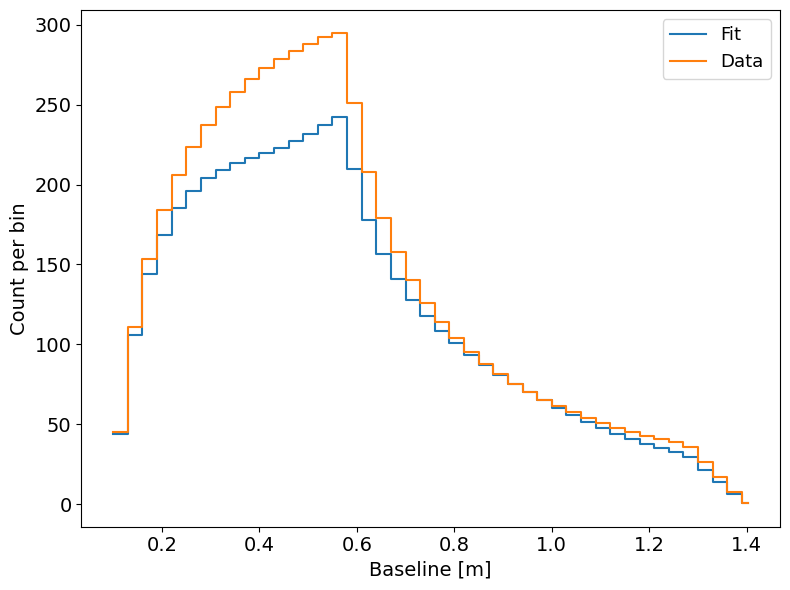

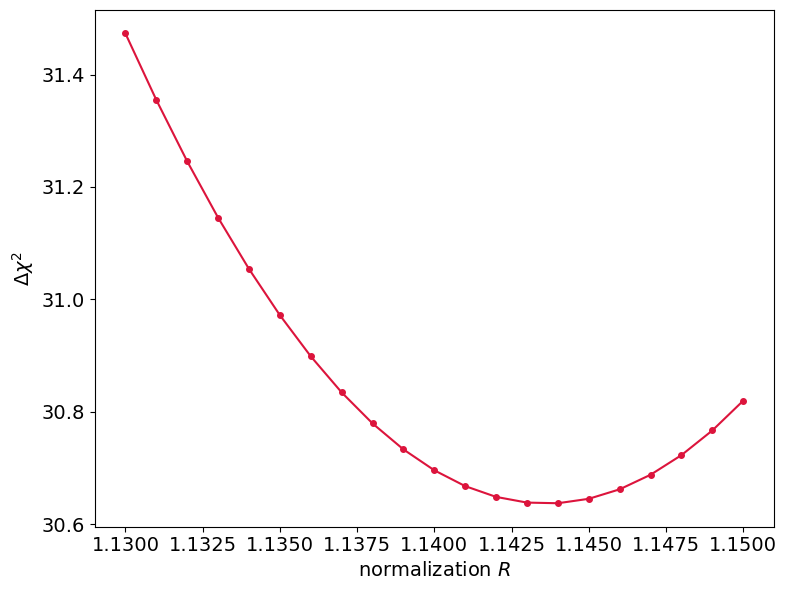

In [14]:
my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)
my_fit._set_fit_dm2(2.0)
my_fit._set_fit_sin2(0.2)
x0, y0, x1, y1, fig = my_fit.calculate_shape_only_dchi2_asimov_scanRate(draw=True)
print(x0[np.argmin(y0)], np.min(y0))
print(x1[np.argmin(y1)], np.min(y1))

fig1, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x0, y0, 'o-', ms=4)
ax.plot(x1, y1, 'o-', ms=4, color='crimson')
ax.set_xlabel(r'normalization $R$', fontsize=14)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()

In [2]:
!pwd

/p/lustre1/yu47/Sterile_Neutrino/sensitivity/notebooks


## Two-dimensional calculation

It seems like the granularity is not fine enough so that the contour plot is not continuous. I submitted multiple jobs to calculate chi2 in smaller grids then.

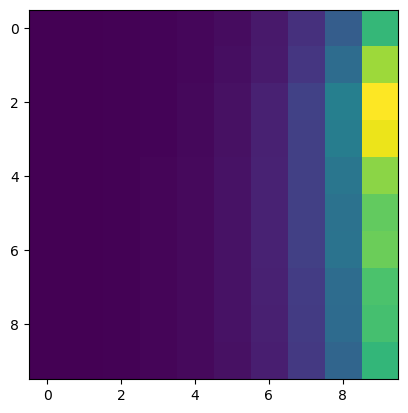

In [33]:

import os
import h5py as h5
path = '/p/lustre1/yu47/Sterile_Neutrino/jobs/Fits/'
filename = 'AsimovFit_shape-only-scan_dm2From0To1_sin2From-1To0_dchi2.h5'

with h5.File(path+filename, 'r') as f:
    dchi2 = f['dchi2'][:]
    

In [9]:
import os
import h5py as h5

def load_2d_chi2map_fromSubfiles(method, dm2min, dm2max, sin2min, sin2max):
    path = '/p/lustre1/yu47/Sterile_Neutrino/jobs/Fits/'

    Ndm2 = int((dm2max - dm2min) * 100)
    Nsin2 = int((sin2max - sin2min) * 100)

    dm2_arr = np.logspace(dm2min, dm2max, Ndm2)
    sin2_arr = np.logspace(sin2min, sin2max, Nsin2)

    dchi2_arr = np.zeros((Ndm2, Nsin2))

    for i in range(dm2max-dm2min):
        for j in range(sin2max-sin2min):
            filename = f'AsimovFit_{method}_dm2From{dm2min+i}To{dm2min+i+1}_sin2From{sin2min+j}To{sin2min+j+1}_dchi2.h5'
            if not os.path.exists(path + filename):
                print(f'{filename} does not exist!')
            print(filename)
            with h5.File(path+filename, 'r') as fin:
                dat = fin['dchi2'][:]

            for x in range(100):
                for y in range(100):
                    row = i * 100 + x
                    col = j * 100 + y
                    dchi2_arr[row, col] = dat[x, y]                   
    return dm2_arr, sin2_arr, dchi2_arr

def load_2d_chi2map(method, dm2min=-2, dm2max=2, sin2min=-3, sin2max=0):
    path = '/p/lustre1/yu47/Sterile_Neutrino/jobs/Fits/'
    fileaname = f'AsimovFit_{method}_dm2From{dm2min}To{dm2max}_sin2From{sin2min}To{sin2max}_dchi2.h5'
    
    Ndm2 = int((dm2max - dm2min) * 100)
    Nsin2 = int((sin2max - sin2min) * 100)
    dm2_arr = np.logspace(dm2min, dm2max, Ndm2)
    sin2_arr = np.logspace(sin2min, sin2max, Nsin2)
    
    if not os.path.exists(path+fileaname):
        print(f'{path+filename} dose not exist !')
        sys.argv(-1)
    with h5.File(path+fileaname, 'r') as f:
        dchi2 = f['dchi2'][:]
    return dm2_arr, sin2_arr, dchi2
            

#dm2_arr, sin2_arr, dchi2_arr_rateonly       = load_2d_chi2map_fromSubfiles('rate-only', 1, 2, -3, 0)
#dm2_arr, sin2_arr, dchi2_arr_shapeonlyfixed = load_2d_chi2map_fromSubfiles('shape-only-fixed', 1, 2, -3, 0)
#dm2_arr, sin2_arr, dchi2_arr_shapeonlyscan  = load_2d_chi2map_fromSubfiles('shape-only-scan', 1, 2, -3, 0)
#dm2_arr, sin2_arr, dchi2_arr_shapeonlyfit  = load_2d_chi2map_fromSubfiles('shape-only-fit', 1, 2, -3, 0)
        

In [16]:
dm2_rateonly, sin2_rateonly, dchi2_rateonly                         = load_2d_chi2map('rate-only', -2, 2, -3, 0)
dm2_shapeonlyfixed, sin2_shapeonlyfixed, dchi2_shapeonlyfixed       = load_2d_chi2map('shape-only-fixed', -2, 2, -3, 0)
dm2_shapeonlyscan, sin2_shapeonlyscan, dchi2_shapeonlyscan          = load_2d_chi2map('shape-only-scan', -2, 2, -3, 0)

/var/tmp/yu47/ipykernel_2477553/358426395.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(CS.collections):
/var/tmp/yu47/ipykernel_2477553/358426395.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(CS.collections):
/var/tmp/yu47/ipykernel_2477553/358426395.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(CS.collections):


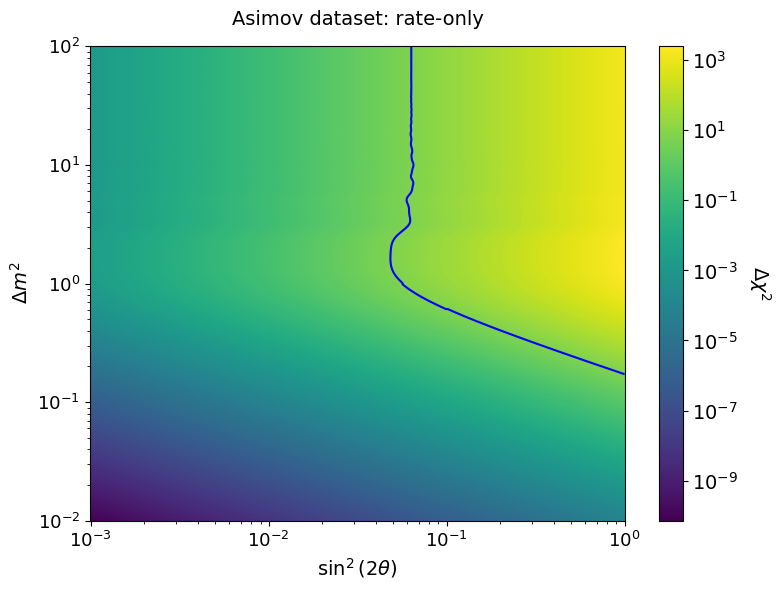

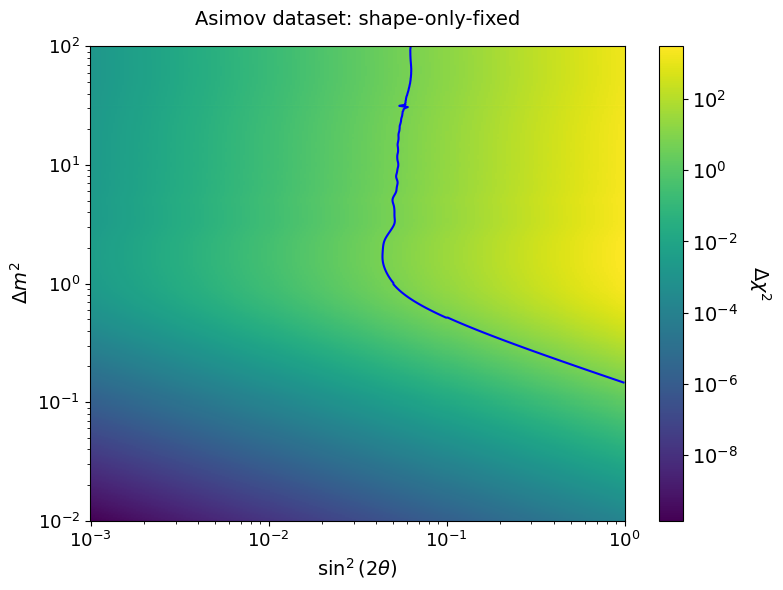

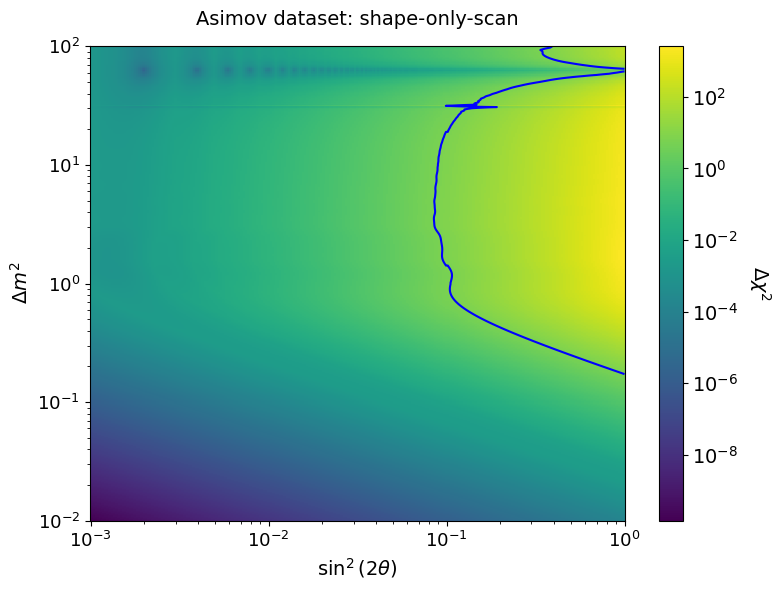

In [59]:
f0, x0, y0 = plot_2d(dm2_rateonly, sin2_rateonly, [], dchi2_rateonly[::-1,:], method='rate-only', plotR=False, contour=True, levels=[ 5.991 ]); f0.savefig('../plots/Asimov_rate-only_binwidth3cm.pdf')
f1, x1, y1 = plot_2d(dm2_shapeonlyfixed, sin2_shapeonlyfixed, [], dchi2_shapeonlyfixed[::-1,:], method='shape-only-fixed', plotR=False, contour=True, levels=[ 5.991 ]); f1.savefig('../plots/Asimov_shape-only-fixed_binwidth3cm.pdf')
f2, x2, y2 = plot_2d(dm2_shapeonlyscan, sin2_shapeonlyscan, [], dchi2_shapeonlyscan[::-1,:], method='shape-only-scan', plotR=False, contour=True, levels=[ 5.991 ]); f2.savefig('../plots/Asimov_shape-only-scan_binwidth3cm.pdf')

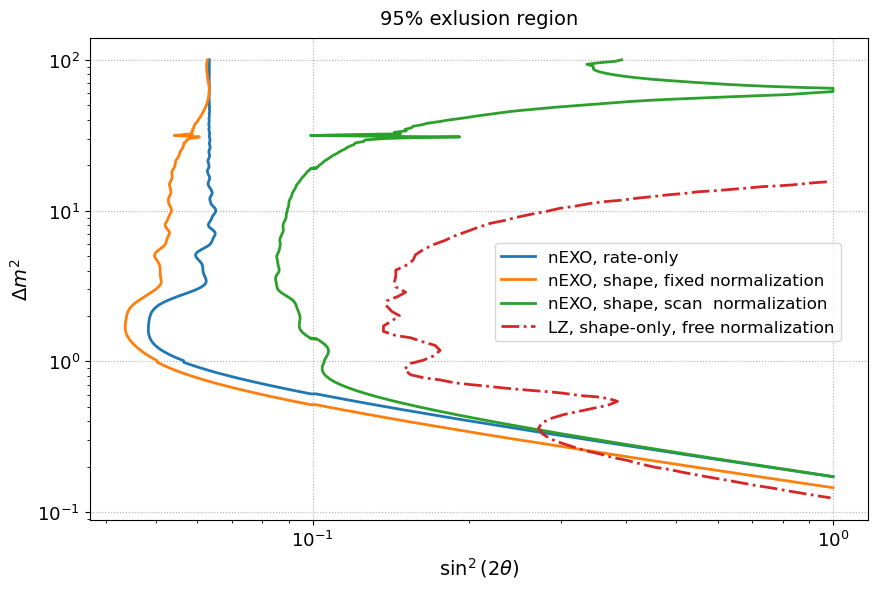

In [58]:
my_fit.other_exp_files = ['/p/lustre1/yu47/Sterile_Neutrino/sensitivity/data/LZ_natural_LXe_shapeonly.csv']
my_fit.load_other_experiments_sensitivity()

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x0[0], y0[0], '-', linewidth=2, label='nEXO, rate-only')
ax.plot(x1[0], y1[0], '-', linewidth=2, label='nEXO, shape, fixed normalization')
ax.plot(x2[0], y2[0], '-', linewidth=2, label='nEXO, shape, scan  normalization')
ax.plot(my_fit.other_exp_sens[0][:, 0], my_fit.other_exp_sens[0][:, 1], lw=2, linestyle='-.', label='LZ, shape-only, free normalization')
ax.loglog()
ax.set_xlabel(r'$\sin^2(2\theta)$', fontsize=14)
ax.set_ylabel(r"$\Delta m^2 $", fontsize=14)
ax.tick_params(labelsize=13)
ax.legend(fontsize=12, loc=(0.52, 0.37))
ax.grid(linestyle=':')
ax.set_title('95% exlusion region', fontsize=14, pad=10)
plt.tight_layout()  
plt.savefig('../plots/AsimovComparison_binwidth3cm.pdf')

## Normalization fit with iminuit 

Instead of manual scanning of the normalization factor $R$, I also implemented a function to fit it by iminuit with LeastSquare method.

In [7]:
my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)
my_fit._set_fit_dm2(1.0)
my_fit._set_fit_sin2(0.1)

R, Rerr, m1,  = my_fit.calculate_shape_only_dchi2_asimov_fitRate(draw=False)

m1


my_fit._set_data_dm2(0.0)
my_fit._set_data_sin2(0.0)
my_fit._set_fit_dm2(0.0)
my_fit._set_fit_sin2(0.0)

R, Rerr, m0,  = my_fit.calculate_shape_only_dchi2_asimov_fitRate(draw=False)

m0

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0 (χ²/ndof = 0.0)          │              Nfcn = 16               │
│ EDM = 2.7e-29 (Goal: 0.0002)     │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R        │   1.000   │   0.013   │            │            │    0    │    2    │       │
│ 1 │ binwidth │  30.0e-3  │  0.3e-3   │            │            │         │         │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │        R binwidth │
├──────────┼───────────────────┤
│        R │ 0.000169        0 │
│ binwidth │        0        0 │
└──────────┴───────────────────┘

In [8]:
print(m0.fval, m1.fval)

0.0 5.5499500605225816
